In [34]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from tqdm.auto import tqdm
from skimage.metrics import peak_signal_noise_ratio
from IPython import display
import cv2
import matplotlib.pyplot as plt
from sr_model import FSRCNN

In [35]:
model = FSRCNN(2).cuda()
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [36]:
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    """
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

In [37]:
img = cv2.imread("urban_dataset_15cm/1.png")

blur_kernel = np.genfromtxt('PSF_E10x2.csv', delimiter=';')


blur_img = cv2.resize(cv2.filter2D(img, -1, blur_kernel), 
                      (img.shape[1]//2, img.shape[0]//2), 
                      interpolation = cv2.INTER_NEAREST)

to_tensor = transforms.ToTensor()
upsampler = nn.Upsample(scale_factor=2, mode='bicubic')

blur_img = to_tensor(blur_img)

bic_img = upsampler(blur_img.unsqueeze(0)).squeeze(0)

In [38]:
n_chan, height, width = blur_img.shape
chunk_size = 128

num_chunks_y = height // chunk_size
num_chunks_x = width // chunk_size

print("n_chunk_y: ", num_chunks_y, "n_chunk_x: ", num_chunks_x)

sr_img = torch.empty((num_chunks_y*2*chunk_size, num_chunks_x*2*chunk_size, 3))

for i in tqdm(range(num_chunks_y)):
    for j in range(num_chunks_x):

        left = j * chunk_size    
        top = i * chunk_size
        right = left + chunk_size
        bottom = top + chunk_size
        
        blur_patch = blur_img[:, top:bottom, left:right].cuda()
        
        with torch.no_grad():
            y_hat = model(blur_patch.cuda().unsqueeze(0)).squeeze(0).permute(1,2,0)

        sr_img[2*top:2*bottom, 2*left:2*right] = y_hat.cpu()
        
sr_img[sr_img>1] = 1

n_chunk_y:  5 n_chunk_x:  6


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
n_patch = 4
patch_size = 64
patch_start_index = [[400,650], [570,550], [400,1350], [750,160]]

In [39]:
blur_img = cv2.cvtColor(blur_img.permute(1,2,0).numpy(), cv2.COLOR_BGR2RGB)
bic_img = cv2.cvtColor(bic_img.permute(1,2,0).numpy(), cv2.COLOR_BGR2RGB)
sr_img = cv2.cvtColor(sr_img.numpy(), cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
blur_patch, bic_patch, sr_patch, img_patch = [], [], [], []
for s in patch_start_index:
    blur_patch.append(blur_img[s[0]//2:s[0]//2+patch_size,  s[1]//2:s[1]//2+patch_size, :])
    bic_patch.append(bic_img[s[0]:s[0]+2*patch_size,  s[1]:s[1]+2*patch_size, :])
    sr_patch.append(sr_img[s[0]:s[0]+2*patch_size,  s[1]:s[1]+2*patch_size, :])
    img_patch.append(img[s[0]:s[0]+2*patch_size,  s[1]:s[1]+2*patch_size, :])

In [41]:
PSNR = []
for i in range(n_patch):
    PSNR.append([psnr(bic_patch[i],img_patch[i]),psnr(sr_patch[i],img_patch[i])])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


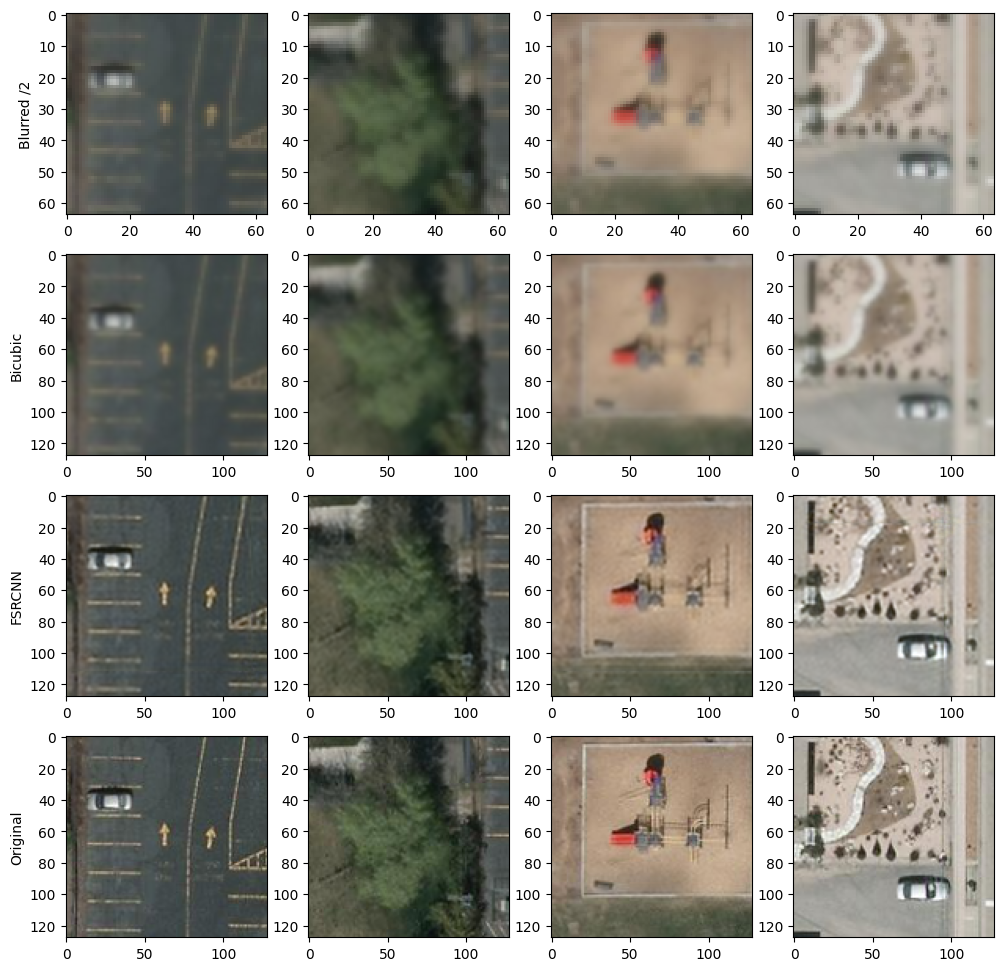

In [43]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

for ax in axes:
    for i in range(4):
        pass#ax[i].set_axis_off()
        
rows = ['Blurred /2', 'Bicubic', 'FSRCNN', 'Original']

for ax, row in zip(axes, rows):
    ax[0].set_ylabel(row)

for i, s in enumerate(patch_start_index):
    axes[0, i].imshow(blur_patch[i])
    axes[1, i].imshow(bic_patch[i])
    axes[2, i].imshow(sr_patch[i])
    axes[3, i].imshow(img_patch[i]) 
plt.savefig('foo.png')